# Import libraries

---


In [23]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!ls
!cat /proc/cpuinfo
!cat /proc/meminfo
!nvidia-smi

drive  sample_data
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import cv2
import glob
import random
import math
from matplotlib import pyplot as plt

# Constant parameters

---



In [26]:
# horiz_x = 800  
# vert_y = 600
horiz_x = 640  
vert_y = 480
batch_size = 16
image_shape = (horiz_x, vert_y, 3)
model_path = '/content/drive/My Drive/Colab Notebooks/Zapisane modele/hand_gesture_classifier.h5'

#drive paths
#
# imgs_train_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Train/'
# imgs_test_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Test/'
#local paths windows
#
# imgs_train_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'
# imgs_test_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'
#local paths manjaro
#
# imgs_train_path = '/home/werdon4/Rozszerzony_dataset/Train'
# imgs_test_path = '/home/werdon4/Rozszerzony_dataset/Test'

#skin data set
imgs_train_path = '/content/drive/My Drive/Colab Notebooks/skin dataset/Train/'
imgs_test_path = '/content/drive/My Drive/Colab Notebooks/skin dataset/Test/'



In [27]:

# class_names = {
#     0: "1",
#     1: "2",
#     2: "3",
#     3: "4",
#     4: "5",
#     5: "A",
#     6: "B",
#     7: "C",
#     8: "D",
#     9: "E",
#     10: "F",
#     11: "G",
#     12: "H",
#     13: "I",
#     14: "K",
#     15: "L",
#     16: "M",
#     17: "N",
#     18: "O",
#     19: "P",
#     20: "R",
#     21: "S",
#     22: "T",
#     23: "U",
#     24: "W",
#     25: "Y",
#     26: "Z"
# }

class_names = {
    0: "1",
    1: "2",
    2: "3",
    3: "4",
    4: "5",
    # 5: "A",
    # 6: "B",
    # 7: "C",
    # 8: "E",
    # 9: "F",
    # 10: "H",
    # 11: "K",
    # 12: "N",
    # 13: "O",
    # 14: "R",
    # 15: "S",
    # 16: "U",
    # 17: "W",
    # 18: "Y",
    # 19: "Z"
}

# Auxiliary functions

---


## Image resize

In [133]:
def img_counter(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        img_counter += len(os.listdir(os.path.join(path, dirname)))

    print("Images in set: " + str(img_counter))
    return img_counter


def resize(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            resized_img = cv2.resize(img, (horiz_x, vert_y))
            cv2.imwrite(image_path, resized_img)
            img_counter += 1
    
    print('Images in set: ' + str(img_counter))


## Image size sanity check

In [29]:

def sanity_check(path):
    counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            if img.shape != (horiz_x, vert_y, 3):
                counter += 1

    print('Sanity result: ' + str(counter))

In [106]:

# def show_img(index, X, Y):
#     # plt.imshow(X[index])
#     plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
#     plt.show()
#     nmb = int(np.where(Y[index] == 1)[0])
#     print("On image: " + class_names[nmb])

def show_img(i, path):
    testlist = glob.glob(f'{path}/*/*')
    img = cv2.normalize(cv2.imread(testlist[i]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    label = testlist[i].split('/')[7]
    label = label.split('_')[1]
    print("Gesture: " + str(label))

    return img

# show_img(100)


## Load dataset

In [31]:

def load_dataset():
    trainlist = glob.glob(f'{imgs_train_path}/*/*')
    testlist = glob.glob(f'{imgs_test_path}/*/*')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in trainlist] )
    X_test = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in testlist] )

    # Y_train = np.array([np.zeros(27) for fname in trainlist])
    Y_train = np.array([0 for fname in trainlist])
    for i,fname in enumerate(trainlist):
        # print(fname)
        img_id = fname.split('/')[7]##7 if windows 4 if manjaro
        img_id = img_id.split('_')[0]
        # Y_train[i][img_id] = 1
        Y_train[i] = img_id


    # Y_test = np.array([np.zeros(27) for fname in testlist])
    Y_test = np.array([0 for fname in testlist])
    for i,fname in enumerate(testlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_test[i][img_id] = 1
        Y_test[i] = img_id

    return X_train, Y_train, X_test, Y_test

# load_dataset()


# Create network model

In [32]:

# def create_model():
model = Sequential()
# kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# kernel_initializer=None 
# initializer = initializers.GlorotUniform(seed=10)
initializer = None
# regularizer = regularizers.l2(l2=0.01)
regularizer = None
activ_func = 'relu'
# kernel_regularizer=None
# activity_regularizer=None

# CONVOLUTIONAL LAYER - 1
model.add(Conv2D(
    filters=6, 
    kernel_size=(5,5), 
    input_shape=(vert_y, horiz_x, 3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))
# CONVOLUTIONAL LAYER - 1
model.add(Conv2D(
    filters=6, 
    kernel_size=(5,5), 
    input_shape=(vert_y, horiz_x, 3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 1
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 2
model.add(Conv2D(
    filters=16, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))
# CONVOLUTIONAL LAYER - 2
model.add(Conv2D(
    filters=16, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 2
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 3
model.add(Conv2D(
    filters=32, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 3
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 4
model.add(Conv2D(
    filters=60, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 4
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 5
model.add(Conv2D(
    filters=120, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 5
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

######## FLATTEN ########
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    # optimizer='adam', 
    # optimizer=SGD(lr=0.01),
    optimizer='rmsprop',
    metrics=['accuracy']
)

    # return model


# Loading dataset

---


## Resize images and do sanity check

In [134]:
# Uncomment before first run on dataset 
# resize(imgs_train_path)
# sanity_check(imgs_train_path)
# resize(imgs_test_path)
# sanity_check(imgs_test_path)
train_set_size = img_counter(imgs_train_path)
test_set_size = img_counter(imgs_test_path)


Images in set: 1062
Images in set: 100


## Load dataset to host memory

In [34]:
# X_train, Y_train, X_test, Y_test = load_dataset()

## Convert labels to one hot encoding

In [35]:
# Y_cat_train = to_categorical(Y_train, 27)
# Y_cat_test = to_categorical(Y_test, 27)

## Data augumentation

## Initializing ImageDataGenerator class

In [36]:
image_gen = ImageDataGenerator(rotation_range=5, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                            #    rescale=1./255, # Rescale the image by normalzing it.
                               shear_range=0.05, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 10% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                                )
                              

## Augumentation sample result

In [37]:
#original img
# nmb = random.randint(0, 296)
# my_hand = X_test[nmb]
# show_img(nmb, X_test, Y_cat_test)

# #generated img
# gen_img = image_gen.random_transform(my_hand)
# print("Generated image")
# plt.imshow(cv2.cvtColor(gen_img,cv2.COLOR_BGR2RGB).astype('float32'))
# plt.show()

# comparison = my_hand == gen_img
# equal_arrays = comparison.all()
# print("Images are equal?: " + str(equal_arrays))

## Initializing test and train image geneartors

In [38]:
train_image_gen = image_gen.flow_from_directory(imgs_train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 1062 images belonging to 5 classes.


In [39]:
test_image_gen = image_gen.flow_from_directory(imgs_test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False)

Found 100 images belonging to 5 classes.


In [40]:
train_image_gen.class_indices

{'0_1': 0, '1_2': 1, '2_3': 2, '3_4': 3, '4_5': 4}

# Train model

---


In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 476, 636, 6)       456       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 472, 632, 6)       906       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 236, 316, 6)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 234, 314, 16)      880       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 232, 312, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 116, 156, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 114, 154, 32)     

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

## Fit model

In [43]:
# model.fit(X_train, Y_cat_train, epochs=12, validation_data=(X_test, Y_cat_test), batch_size=batch_size, callbacks=[early_stop])

## Fit model with data augumentation

In [44]:
results = model.fit(train_image_gen, epochs=64, validation_data=test_image_gen, verbose=2, callbacks=[early_stop])

Epoch 1/64
67/67 - 350s - loss: 2.3283 - accuracy: 0.5009 - val_loss: 0.6785 - val_accuracy: 0.8200
Epoch 2/64
67/67 - 73s - loss: 0.6384 - accuracy: 0.7580 - val_loss: 0.2982 - val_accuracy: 0.8600
Epoch 3/64
67/67 - 72s - loss: 0.4590 - accuracy: 0.8267 - val_loss: 0.3652 - val_accuracy: 0.9200
Epoch 4/64
67/67 - 71s - loss: 0.3290 - accuracy: 0.8832 - val_loss: 0.2352 - val_accuracy: 0.9300
Epoch 5/64
67/67 - 70s - loss: 0.2393 - accuracy: 0.9162 - val_loss: 0.1703 - val_accuracy: 0.9500
Epoch 6/64
67/67 - 68s - loss: 0.2187 - accuracy: 0.9247 - val_loss: 0.0668 - val_accuracy: 0.9800
Epoch 7/64
67/67 - 67s - loss: 0.1547 - accuracy: 0.9529 - val_loss: 0.1240 - val_accuracy: 0.9600
Epoch 8/64
67/67 - 67s - loss: 0.1676 - accuracy: 0.9360 - val_loss: 0.1539 - val_accuracy: 0.9500
Epoch 9/64
67/67 - 67s - loss: 0.1017 - accuracy: 0.9586 - val_loss: 0.1410 - val_accuracy: 0.9700
Epoch 10/64
67/67 - 66s - loss: 0.1198 - accuracy: 0.9661 - val_loss: 0.0422 - val_accuracy: 0.9800
Epoch 11

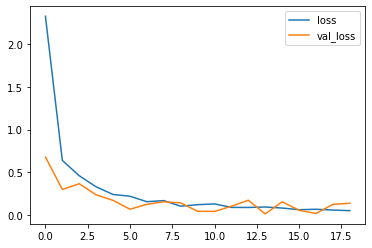

In [45]:
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

## Saving model to file

In [46]:
# model.save(model_path)

# Results

---


In [47]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,2.328294,0.500942,0.678512,0.82
1,0.638354,0.758004,0.298244,0.86
2,0.459013,0.826742,0.365156,0.92
3,0.328964,0.883239,0.235222,0.93
4,0.239344,0.916196,0.170334,0.95
5,0.218690,0.924670,0.066783,0.98
6,0.154739,0.952919,0.123997,0.96
7,0.167584,0.935970,0.153941,0.95
8,0.101736,0.958569,0.140970,0.97
9,0.119813,0.966102,0.042224,0.98


## Single image prediction

In [48]:
# model = load_model(model_path)
# model = create_model()
# model.load_weights(model_path)

-------------
/content/drive/My Drive/Colab Notebooks/skin dataset/Train/3_4/4_P_hgr1_id10_2 - Copy.bmp
Gesture: 4
[[0.19763027 0.22286446 0.20882034 0.18926    0.18142487]]
[1]
CNN says: 2
-------------
/content/drive/My Drive/Colab Notebooks/skin dataset/Train/0_1/1_P_hgr1_id09_1.bmp
Gesture: 1
[[0.20051472 0.2258586  0.20803653 0.18402562 0.18156448]]
[1]
CNN says: 2
-------------
/content/drive/My Drive/Colab Notebooks/skin dataset/Train/1_2/2_P_hgr1_id02_1 - Copy (6).bmp
Gesture: 2
[[0.2002224  0.22701453 0.20826426 0.18398853 0.1805103 ]]
[1]
CNN says: 2
-------------
/content/drive/My Drive/Colab Notebooks/skin dataset/Train/1_2/2_P_hgr1_id08_4 - Copy (2).bmp
Gesture: 2
[[0.20541684 0.23161055 0.20639381 0.18136913 0.17520963]]
[1]
CNN says: 2
-------------
/content/drive/My Drive/Colab Notebooks/skin dataset/Train/3_4/4_P_hgr1_id12_1 - Copy (6).bmp
Gesture: 4
[[0.21433918 0.24150999 0.20238838 0.17724434 0.16451807]]
[1]
CNN says: 2
-------------
/content/drive/My Drive/Colab N

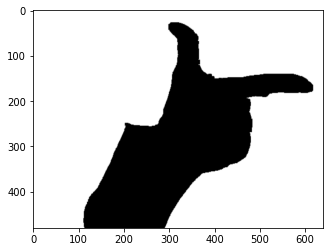

In [83]:
# for i in range(10):
#     print("-------------")
#     nmb = random.randint(1, 1060)
#     my_hand = show_img(nmb)
#     # print(my_hand)
#     # show_img(nmb)
#     # my_hand = my_hand.reshape(1, vert_y, horiz_x, 3)
#     my_hand = np.expand_dims(my_hand, axis=0)
#     # print(my_hand)
#     # result = model.predict_classes(my_hand)
#     result = model.predict(my_hand)
#     print(result)
#     result = np.argmax(result, axis=-1)
#     # result = model.predict(my_hand)
#     print(result)
#     # result = (CNN.predict(my_hand) > 0.5).astype("int32")
#     result = int(result)
#     print('CNN says: ' + class_names[result])

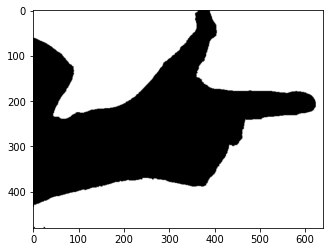

Gesture: 2
Class prediction: 
1: 0.0% 2: 100.0% 3: 0.0% 4: 0.0% 5: 0.0% 
CNN says: 2


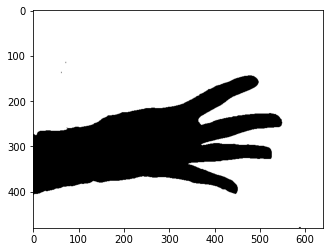

Gesture: 4
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 100.0% 5: 0.0% 
CNN says: 4


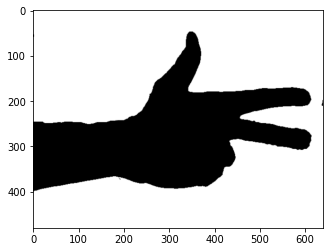

Gesture: 3
Class prediction: 
1: 0.0% 2: 0.0% 3: 100.0% 4: 0.0% 5: 0.0% 
CNN says: 3


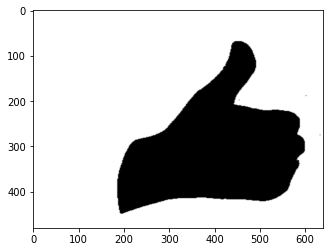

Gesture: 1
Class prediction: 
1: 100.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% 
CNN says: 1


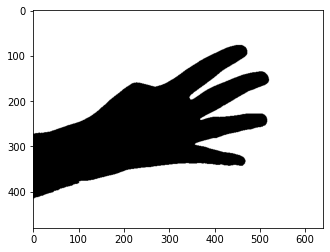

Gesture: 4
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 100.0% 5: 0.0% 
CNN says: 4


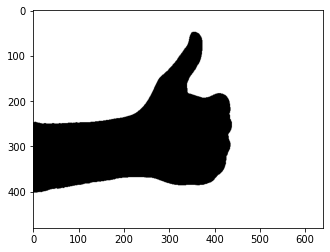

Gesture: 1
Class prediction: 
1: 100.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% 
CNN says: 1


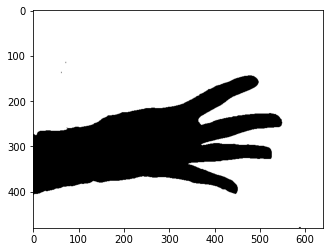

Gesture: 4
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 100.0% 5: 0.0% 
CNN says: 4


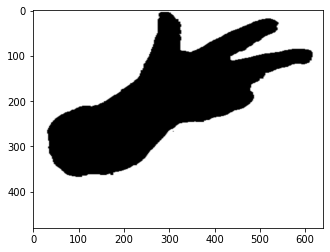

Gesture: 3
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 100.0% 5: 0.0% 
CNN says: 4


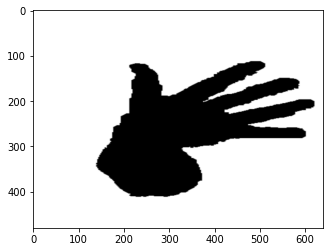

Gesture: 5
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 100.0% 
CNN says: 5


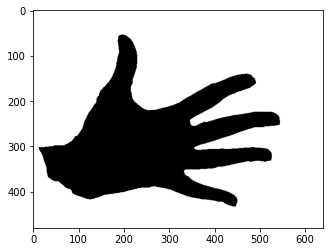

Gesture: 5
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 100.0% 
CNN says: 5


In [136]:
imgslist = glob.glob(f'{imgs_test_path}/*/*')

for i in range(10):
    nmb = random.randint(1, test_set_size)
    show_img(nmb, imgs_test_path)
    single_img = imgslist[nmb]
    single_img = image.load_img(single_img, target_size=(horiz_x, vert_y, 3))
    single_img = image.img_to_array(single_img)
    single_img = np.expand_dims(single_img, axis=0)
    prediction = model.predict(single_img)
    print('Class prediction: ')
    # print(prediction[0])
    for i, prc in enumerate(prediction[0]):
        print(class_names[i] +": " + str(100*round(prc, 2)) + '%', end=" ")
    prediction = np.argmax(prediction, axis=-1)
    print('\nCNN says: ' + class_names[int(prediction)])




## Predictions for individual classes

In [51]:
# predictions = model.predict_classes(test_image_gen)
predictions = np.argmax(model.predict(test_image_gen), axis=-1)

In [52]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.95      0.95      0.95        20
           2       0.95      0.90      0.92        20
           3       0.91      1.00      0.95        20
           4       1.00      0.90      0.95        20

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [53]:
confusion_matrix(test_image_gen.classes,predictions)

array([[20,  0,  0,  0,  0],
       [ 1, 19,  0,  0,  0],
       [ 0,  1, 18,  1,  0],
       [ 0,  0,  0, 20,  0],
       [ 0,  0,  1,  1, 18]])

# Unmount Google drive

In [54]:
# drive.flush_and_unmount()